In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd=320):
        super().__init__()
        self.linear_1 = nn.Linear(1, n_embd)
        self.linear_2 = nn.Linear(n_embd, n_embd)

    def forward(self, t):
        x = self.linear_1(t)
        x = F.silu(x)
        x = self.linear_2(x)
        return x

In [3]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=320):
        super().__init__()
        num_groups_feature = min(in_channels, 32)
        num_groups_merged = min(out_channels, 32)

        self.groupnorm_feature = nn.GroupNorm(num_groups_feature, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)
        self.groupnorm_merged = nn.GroupNorm(num_groups_merged, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.residual_layer = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, feature, time):
        residue = feature
        x = F.silu(self.groupnorm_feature(feature))
        x = self.conv_feature(x)
        time = F.silu(time)
        time = self.linear_time(time).unsqueeze(-1).unsqueeze(-1)
        merged = x + time
        merged = F.silu(self.groupnorm_merged(merged))
        merged = self.conv_merged(merged)
        return merged + self.residual_layer(residue)

In [4]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

In [5]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=3): # Default to 3 for RGB images
        super().__init__()
        self.enc1 = UNET_ResidualBlock(in_channels, 128)
        self.enc2 = UNET_ResidualBlock(128, 256)

        # Bottleneck:
        self.bottleneck = UNET_ResidualBlock(256, 256)

        # Decoding
        self.dec1 = UNET_ResidualBlock(256, 128)
        self.dec2 = UNET_ResidualBlock(128, out_channels)

    def forward(self, x, time_emb):
        x = self.enc1(x, time_emb)
        x = self.enc2(x, time_emb)
        x = self.bottleneck(x, time_emb)
        x = self.dec1(x, time_emb)
        x = self.dec2(x, time_emb)
        return x

In [6]:
class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        num_groups = max(1, min(32, in_channels))
        self.groupnorm = nn.GroupNorm(num_groups, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.silu(self.groupnorm(x))
        x = self.conv(x)
        return x

In [7]:
class Diffusion(nn.Module):
    def __init__(self, in_channels=3, unet_output_channels=3):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET(in_channels=in_channels, out_channels=unet_output_channels)
        self.final = UNET_OutputLayer(unet_output_channels, unet_output_channels)

    def forward(self, latent, time):
        time = self.time_embedding(time)
        x = self.unet(latent, time)
        x = self.final(x)# final predicted noise
        return x

In [8]:
def reverse_diffusion(diffusion_model, scheduler, shape, device):
    B, C, H, W = shape
    x_t = torch.randn(shape, device=device)

    for t in reversed(range(scheduler.T)):
        beta_t, alpha_t, alpha_hat_t = scheduler.get(t)
        time_tensor = torch.full((B, 1), t / scheduler.T, device=device)


        predicted_noise = diffusion_model(x_t, time_tensor)

        # reverse step
        x_t = (x_t - beta_t * predicted_noise) / torch.sqrt(alpha_t)

    return x_t

In [9]:
class DiffusionScheduler:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.T = T
        self.device = device

        self.beta = torch.linspace(beta_start, beta_end, T, device=device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def get(self, t):
        return self.beta[t], self.alpha[t], self.alpha_bar[t]


In [10]:
def forward_diffusion(x0, t,scheduler):

   noise=torch.randn_like(x0)

   _,_, alpha_bar_t=scheduler.get(t)
   xt=torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1-alpha_bar_t)*noise

   return xt,noise


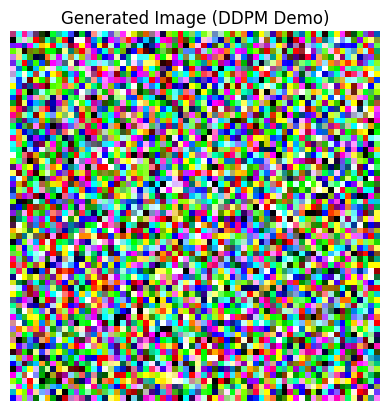

Generated image shape: torch.Size([1, 3, 64, 64])


In [11]:
import torch
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


diffusion_model = Diffusion(in_channels=3, unet_output_channels=3).to(device)
scheduler = DiffusionScheduler(T=50, device=device)

# Taking Fake image (for demo)
x0 = torch.randn(1, 3, 64, 64, device=device)

# Forward diffusion example
t = torch.randint(0, scheduler.T, (1,), device=device)
xt, _ = forward_diffusion(x0, t, scheduler)

# Reverse diffusion (sampling)
generated_image = reverse_diffusion(
    diffusion_model,
    scheduler,
    shape=(1, 3, 64, 64),
    device=device
)

generated_image = torch.clamp(generated_image, -1, 1)
generated_image = (generated_image + 1) / 2  # normalize to [0,1]


img_np = generated_image[0].permute(1, 2, 0).cpu().detach().numpy()
plt.imshow(img_np)
plt.axis("off")
plt.title("Generated Image (DDPM Demo)")
plt.show()

print("Generated image shape:", generated_image.shape)